   # Mathematics of Machine Learning

## Workbook 1: Linear Regression

We'll need to develop a few *basic* concepts from Numerical Analysis before we talk about linear regression.  

### The (*relative*) Condition Number

The (relative) condition number of a function $f(x)$ is the ratio of 
the the change in outputs of $f(x)$ to the change in inputs of $f(x)$, i.e.
$$
\frac{\frac{\| \delta f(x) \|}{\| f(x) \|}}{\frac{\|\delta x\|}{\| x \|}}
$$
where $\| \|$ denotes *norms*(think length measures in Euclidean Space) on
the input and output spaces.

The condition number is a *worst-case* measure of what happens to outputs
corresponding to inputs near a fixed $x$.

Solving a system of equations $Ax=b$ can be written explictly as $x=A^{-1}b$.  Here the inputs are the data $b$ and matrix $A$ and the output is the solution vector $x$.

Consider the case when 
$$
A=\begin{pmatrix} 1 & 1 \\ 1 & 1+10^{-5} \end{pmatrix}, \quad b=[1,1]^\top
$$
The inverse of $A$, $A^{-1}$ is
$$
10^5\begin{pmatrix} 1+10^{-5} & -1 \\ -1 & 1 \end{pmatrix}
$$

Clearly, $x=[1 \quad 0]^\top$.  Let's see what happens to $x$ if we allow small variations in just the data $b$.


/Users/Undertrick/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


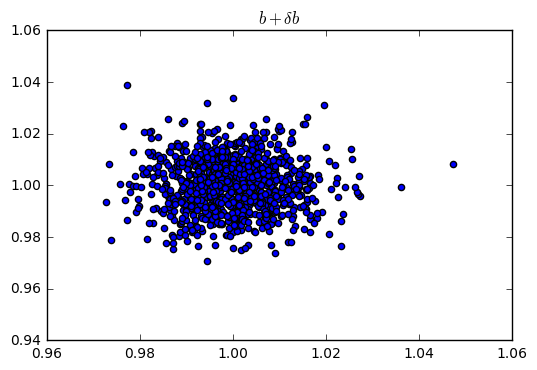

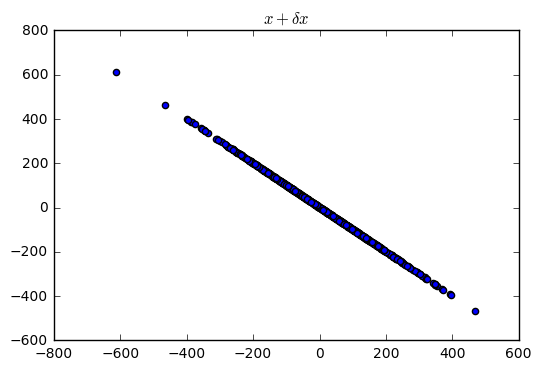

In [1]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
%matplotlib inline

Ainv=1E4*np.array([[1+1E-4,-1],[-1,1]])
perturb=1E-2*np.random.randn(2,1000)
b=perturb+np.ones((2,1000))

x=np.dot(Ainv,b)

plt.scatter(b[0],b[1])
plt.title('$b+\delta b$')
plt.show()
plt.scatter(x[0],x[1])
plt.title('$x+\delta x$')
plt.show()

Ouch!  The **condition number** is a warning that this dangerous sensitivity to perturbations is present in your problem.

From the standpoint of regression, a large **condition number** is a warning of *collinearity*.

Def'n(from Wikipedia)
**multicollinearity** (also collinearity) is a phenomenon in which two or more predictor variables in a multiple regression model are *highly correlated*, meaning that one can be linearly predicted from the others with a substantial degree of accuracy. In this situation the *coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data*.

### A Regression Example

Let's look at an example from *multivariable regression*:

We are fitting $y=\beta_0 + \beta_1 x_1+ \beta_2 x_2 + \ldots + \beta_{p-1} x_{p-1} +\beta_p x_p + \epsilon$ given $N$ data points.

The design matrix $X$ is $(\vec{1} \quad \vec{x_1} \quad \vec{x_2} \ldots  \quad \vec{x_{p-1}} \quad \vec{x}_p$).

The "classical" method for regression involves forming the **normal equations**  
$$X^\top X \vec{\beta} = X^\top \vec{y}$$
and solving for $\beta$ by using the Cholesky factorization(producing an upper triangluar matrix $U$ such that $U^\top U=X^\top X$). The linear model $\hat{y}$ is equal to $X\beta$.

The cost of using Cholesky: 
1. Form the normal equations $\mathcal{O}(Np^2)$.
2. Compute the Cholesky factorization $\mathcal{O}(p^3)$
3. Compute $\beta$ via two substitution sweeps $\mathcal{O}(p^2)$.

There are *slower* methods (at least twice as slow for $N>>p$) that produce more reliable results in the case of **collinearity**/**ill-conditioning**(big condition number)

Let's look at an example where $x_n$ is collinear with the other predictors $x_i$.


In [2]:
def true_observed(input,weights):
    return np.dot(input,weights)

N=100
p=10
x=np.matrix(np.random.randn(N,p)) 

Here we take $y$ as the mean of the $x_i$ + some "small" noise

In [3]:
xn=np.mean(x,axis=1)+1E-4*np.random.randn(N,1)
#xn=np.dot(x,np.random.rand(p,1))
#print xn

If we look at individual scatter plots there aren't any huge warning signs

<function matplotlib.pyplot.show>

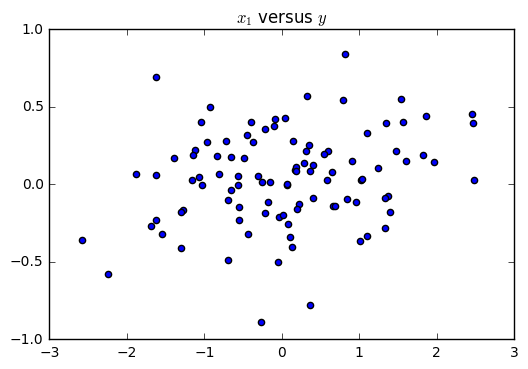

In [4]:
plt.scatter(x[:,0],xn)
plt.title('$x_1$ versus $y$')
plt.show

In [37]:
design_matrix=np.hstack((x,xn))
weights=np.random.rand(p+1,1)
print 'True linear model of predictors=\n',weights
obs_data=true_observed(design_matrix,weights)+1E-14*np.random.randn(N,1)
#print obs_data

True linear model of predictors=
[[ 0.70797395]
 [ 0.71022331]
 [ 0.67560875]
 [ 0.91513418]
 [ 0.03709868]
 [ 0.10575786]
 [ 0.20065733]
 [ 0.70895862]
 [ 0.38715403]
 [ 0.4976809 ]
 [ 0.2375725 ]]


We now proceed to solve the problem using the *Normal Equations Method*

In [38]:
normal_matrix=design_matrix.transpose()*design_matrix

The condition number of the normal matrix $X^\top X$ is

In [39]:
print 'Condition number of solving normal equations',np.linalg.cond(normal_matrix)

Condition number of solving normal equations 200165739.91


This is equal to $\| (X^\top X)^{-1} \| \|X^\top X \|$

The condition number of *the least-squares problem* is actually dominated by (in cases where the model reasonably matches the observed data)
$\| (X^\top X)^{-1} X^\top \|^{-1} \| X \|$.

In [40]:
print 'Least squares condition number roughly',np.linalg.cond(design_matrix)

Least squares condition number roughly 14147.994199


This is roughly the **square root** of the condition number of the normal equations method.

Let's compute the regression using this method, and another method based on orthogonal decomposition.

We then plot the "error" in the linear model coefficients.

[[ 0.70797395]
 [ 0.71022331]
 [ 0.67560875]
 [ 0.91513418]
 [ 0.03709868]
 [ 0.10575786]
 [ 0.20065733]
 [ 0.70895862]
 [ 0.38715403]
 [ 0.4976809 ]
 [ 0.2375725 ]]


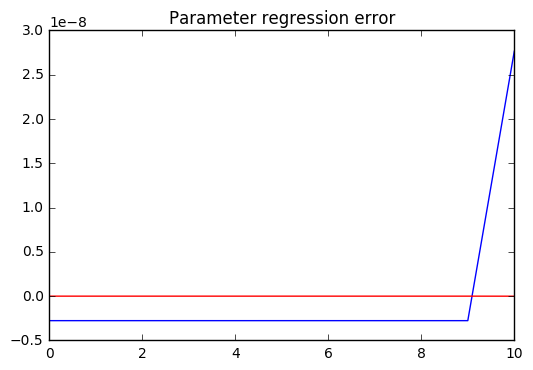

In [41]:
rhs=np.dot(design_matrix.transpose(),obs_data) 
# regres=np.linalg.solve(normal_matrix,rhs) 
regres=sp.solve(normal_matrix,rhs,sym_pos=True)
#print regres
#print np.mean(regres)
least=np.linalg.lstsq(design_matrix,obs_data)
regres2=least[0]
print regres2
plt.plot(regres-weights)
plt.plot(regres2-weights,'r')
plt.title('Parameter regression error')
plt.show()

We also produce a new set of noise-free test data for a linear model and look at $y_{test}-\hat{y}_{test}$.

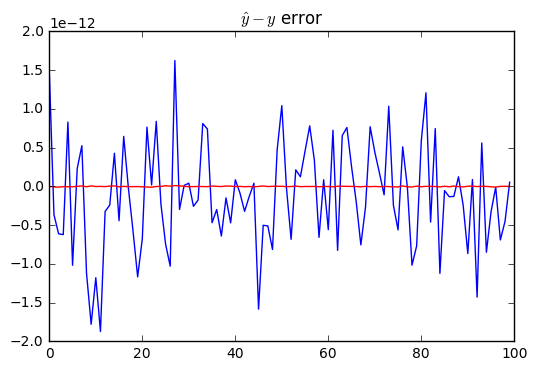

In [42]:
#print np.mean(regres2)
xt=np.matrix(np.random.randn(N,p)) 
xnt=np.mean(xt,axis=1)#+1E-8*np.random.randn(N,1)
test_data=np.hstack((xt,xnt))
truth=true_observed(test_data,weights)
reg1_pred=np.dot(test_data,regres)
reg2_pred=np.dot(test_data,regres2)
plt.plot(reg1_pred-truth)
plt.plot(reg2_pred-truth,color='r')
plt.title("$\hat{y}-y$ error")
plt.show()
#print reg1_pred-reg2_pred
                    

The second solution method for this regression problem used the method of **orthogonal decomposition**.   There are **three** important orthogonal decomposition methods that are often used in regression

1. Gram-Schmidt (Triangular Orthogonalization)
2. QR-Factorization (Orthogonal Triangularization)
3. The Singular Value Deomposition(SVD)-(*Principal Component Analysis*)

### Gram-Schmidt Orthogonalization
You've probably seen Gram-Schmidt before in a linear algebra class.  

Regression by Successive Orthogonalization.
1. Initialize $z_0 = x_0 = \vec{1}.$
2. For $j = 1, 2, \ldots , p$
Regress $x_j$ on $z_0, z_1, \ldots  , z_{j−1}$ to produce coefficients 
$\alpha_{ij} = \frac{(z_i,x_j)}{(z_i,z_i)}, z_i= 0, \ldots j − 1$ and residual vector $z_j =x_j − \sum_{k=0}^{k=j} \alpha_{kj} z_k$.
3. Regress $y$ on the residual $z_p$ to give the estimate $\beta_p$.

**From *Elements of Machine Learning* **

The multiple regression coefficient $\beta_j$ represents the additional
contribution of $x_j$ on $y$, after $x_j$ has been adjusted for $x_0$, $x_1$, $\ldots$, $x_{j−1}$, $x_{j+1}$, $\ldots$, $x_p$.

If $x_p$ is *highly correlated* with some of the other $x_k$'s, the
residual vector $z_p$ will be almost zero, and the coefficient $\beta_p$ will be very unstable.




The G-S orthogonalization Algorithm above produces **orthogonal** but not **orthonormal** vectors; $(z_i,z_i) \neq 0$, but may not be equal to unity.

If we normalize the entries $Z$, and adjust (by multiplying the upper triangular matrix of weights $\alpha_{ij}$ by the inverse of the normalization factor, we get the **QR-factorization** of the design matrix $X$.  $Q$ is an orthogonal matrix ($Q^\top Q = I$ if the rank of $X=p+1$)with the same size as $X$ and $R$ is upper triangular with size ($p+1\times p+1$).  

In *numerical linear algebra* this is called the *reduced* QR-factorization.  

The columns of $Q$ form an orthonormal basis for the column space of the design matrix.  The regression parameters $\vec{\beta}$ is given by
$R^{-1} Q^\top \vec{y}$ while the linear model output is given by $\hat{y}=QQ^\top y$. 

### QR-factorization via other methods

The GS orthonormalization process produces an orthogonal matrix $Q$ with the same column space of $X$.  There are methods based on orthogonal triangulation  (Householder reflections, Givens Rotations) which produce $R$ in a manner and sequentially build up $Q^\top y$. These have better numerical properties in terms of **stability** in floating-point arithmetic but are (a little) harder to connect to regression.

### The SVD

Our final orthogonal decomposition is the **Singular Value Decomposition**, or SVD, which decomposes our design matrix as 
$X=U \Sigma V^\top$, where $U(N\times p)$ and $V(p\times p)$ are orthogonal matrices and $\Sigma$ is a diagonal matrix containing the square root of the eigenvalues of $X^\top X$, such that $Xv_i=\sigma_i u_i$.  

Note that as 
$$X^\top X \beta = X^\top y$$
$$V \Sigma U^\top U \Sigma V^\top \beta = V \Sigma U^\top y$$
$$V \Sigma^2 V^\top \beta = V \Sigma U^\top y$$
$$ \Sigma^2 V^\top \beta = \Sigma U^\top y$$
$$ \beta = V \Sigma^{-1} U^\top y $$ 
and
$$ \hat{y} = X\beta = U U^\top y $$

Not that if $X$ does not have full rank, or *numerically* doesn't have full rank, the SVD will identify the degree of departure from full rank.  Small singular values(near 0) correspond to rank-deficiency.

The SVD is the slowest of the algorithms for regression, as it involves two steps-a transformation to a more simplified form and then an iterative process for determining the eigenvalues of this form(put on board).



## Subset Selection (Model Selection)

We may not want to perform the regression on all the data.  Of course, given $p$ predictors we can test the power set of the predictors, which has a brute force size of $2^p$ regression problems.  There are direct methods for working with this set, based on branching and bounding, that 
I will not go into today.

Alternatively, we can start with two approaches:

1. **Backward-Stepwise Selection** Start with the full model of $p$ predictors, and throw out predictors that have the least impact on the fit.  To test, we use the $Z$-score,
$$
Z_j = \frac{\beta_j}{\hat{\sigma} \sqrt{e_j^\top (X^\top X)^{-1} e_j}}
$$
where $\hat{\sigma}$ is an estimate of the variance, namely
$$
\hat{\sigma}^2=\frac{1}{N-p-1} \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \frac{1}{N-p-1} \| y - \hat{y} \|^2,
$$
an unbiased estimator for $\sigma^2$.

The $Z$-test tests the null hypothesis on $\beta_j=0$.  We don't actually
compute the inverse explicitly. (Done on board, to be added later).

2. **Forward-Stepwise Selection** Start with $\beta_0$ and select the next predictor to add that most improves the fit. This can be done efficiently via the QR factorization.

    1. Given a QR factorization on the current set of  $N\times j$, $j < p$. predictors, and a residual vector $r_j$. 
    2. Orthogonalize the remaining $p-j$ predictors against the columnspace of $QR_j$, and add the predictor that maximizes $|(r_j,\tilde{x}_j)|$ to the $QR$ factorization(Now $Q$ is $N\times j+1$ and $R$ is $j+1\times j+1$.).
    3. Return to Step 1(or stop if $r_j$ meets a specified tolerance).

    One could do something similar with the SVD.


My alternative solver actually used the SVD of our design matrix $X$.  We had one collinear predictor (the last one).  Here are the oredered singular values of $X$.

In [11]:
print 'Singular values of X\n',least[3]

Singular values of X
[  1.34147050e+01   1.16766815e+01   1.09057594e+01   1.01066950e+01
   9.73242652e+00   9.11596630e+00   8.64201329e+00   7.59017869e+00
   7.37554430e+00   6.99838029e+00   9.48170094e-04]


Let's look at the most singular vector of $X$, $X v_{11} = \sigma_{11} u_{11}$.

In [12]:
SVD=np.linalg.svd(design_matrix, full_matrices=False)
V=SVD[2]
print 'nearly singular vector of X',V[p]

nearly singular vector of X [[ 0.09534312  0.09533831  0.09534627  0.09533486  0.09536028  0.09533897
   0.09534737  0.09535479  0.09535746  0.09534273 -0.95346243]]


This is almost (up to the noise we added) the collinearity relationship we imposed (behind the scenes) on the predictors.


Next time we'll look more at the statistical side of linear regression at discuss *shrinkage* or *regularization* methods for regression that reduce variance at the cost of increased bias.  However, the net effect will allow us to reduce complexity while increasing predictive accuracy.